In [1]:
import zipfile
import os
import numpy as np
import pandas as pd
import json
import numpy as np
from numpy.random import rand
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from tqdm.notebook import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def unzip_files_in_folder(directory, output_folder=None):
    # If no output folder specified, unzip files in the same directory
    if output_folder is None:
        output_folder = directory

    # List all files in the directory
    for file in os.listdir(directory):
        if file.endswith(".zip"):
            # Construct full file path
            file_path = os.path.join(directory, file)
            # Create a ZipFile object
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                # Extract all the contents into the output directory
                zip_ref.extractall(output_folder)
                print(f"Extracted {file} in {output_folder}")

# Specify the directory containing the zip files
source_directory = '/content/drive/MyDrive/Overture course/Ouverture/'
output_directory = ''  # Optional: specify if different from source_directory
unzip_files_in_folder(source_directory, output_directory)

Extracted MixAll_0024.zip in 


In [5]:
def unzip_files_in_folder(directory, output_folder=None):
    # If no output folder specified, unzip files in the same directory
    if output_folder is None:
        output_folder = directory

    # List all files in the directory
    for file in os.listdir(directory):
        if file == "VeReMi_64800_68400_2022-9-11_12.51.1.zip":
            # Construct full file path
            file_path = os.path.join(directory, file)
            # Create a ZipFile object
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                # Extract all the contents into the output directory
                zip_ref.extractall(output_folder)
                print(f"Extracted {file} in {output_folder}")

# Specify the directory containing the zip files
source_directory = '/content/drive/MyDrive/Overture course/Ouverture/'
output_directory = ''  # Optional: specify if different from source_directory
unzip_files_in_folder(source_directory, output_directory)
# Specify the directory containing the zip files
source_directory = 'MixAll_0024'
output_directory = 'MixAll_0024_unzipped'  # Optional: specify if different from source_directory
unzip_files_in_folder(source_directory, output_directory)

Extracted VeReMi_64800_68400_2022-9-11_12.51.1.zip in MixAll_0024_unzipped


# Import other files

In [6]:
def read_json_file(file_path):
    data = []  # List to store the selected items
    with open(file_path, 'r') as file:
        for line in file:
            json_obj = json.loads(line)  # Parse the JSON data from the line
            if json_obj['type'] == 3:  # Check if the 'type' is 3
                keys = ["rcvTime","sendTime","sender",'pos', 'pos_noise', 'spd', 'spd_noise', 'acl', 'acl_noise', 'hed', 'hed_noise']
                # For each 3D list (like 'pos', 'spd', etc.), split it into individual components
                for key in ['pos', 'pos_noise', 'spd', 'spd_noise', 'acl', 'acl_noise', 'hed', 'hed_noise']:
                    if key in json_obj:
                        json_obj[f'{key}_x'], json_obj[f'{key}_y'], json_obj[f'{key}_z'] = json_obj[key]
                        del json_obj[key]  # Remove the original key with the list
                data.append(json_obj)  # Add the modified object to the list
    df = pd.DataFrame(data).dropna()
    return df

In [7]:
# List to store DataFrames converted to numpy arrays
numpy_arrays = []
client_names = []
messages_ids = []
ground_truths = []
# gt_set = set(gt_list)
directory_path= '/content/MixAll_0024_unzipped/VeReMi_64800_68400_2022-9-11_12:51:1'
columns = ['type', 'rcvTime', 'sendTime','sender', 'senderPseudo', 'messageID',
           'pos_x', 'pos_y', 'pos_z','pos_noise_x', 'pos_noise_y', 'pos_noise_z',
           'spd_x', 'spd_y','spd_z','spd_noise_x', 'spd_noise_y', 'spd_noise_z',
           'acl_x', 'acl_y', 'acl_z', 'acl_noise_x','acl_noise_y', 'acl_noise_z',
           'hed_x', 'hed_y', 'hed_z', 'hed_noise_x','hed_noise_y', 'hed_noise_z',
           'receiver','attack_type','attack_bin']
features = ['pos_x', 'pos_y', 'pos_z', 'pos_noise_x', 'pos_noise_y', 'pos_noise_z',
            'spd_x', 'spd_y','spd_z','spd_noise_x', 'spd_noise_y', 'spd_noise_z',
            'acl_x', 'acl_y', 'acl_z', 'acl_noise_x','acl_noise_y', 'acl_noise_z',
            'hed_x', 'hed_y', 'hed_z','hed_noise_x','hed_noise_y', 'hed_noise_z']

In [8]:
revievers_attacks = []
# Iterate over each file in the given directory
for filename in os.listdir(directory_path):
    if filename.endswith('.json') and 'groundtruth' not in filename.lower():  # Check if the file is a JSON file
        revievers_attacks.append((int(filename.split('-')[1]) , filename.split('-')[3]))
receiver_df = pd.DataFrame(revievers_attacks, columns = ['receiver' , 'attack_type'])
receiver_df['attack_bin'] = [0 if i == 'A0' else 1 for i in receiver_df.attack_type]

In [9]:
# Iterate over each file in the given directory
for filename in os.listdir(directory_path):
    if filename.endswith('.json') and 'groundtruth' not in filename.lower():  # Check if the file is a JSON file
        file_path = os.path.join(directory_path, filename)
        df = read_json_file(file_path)  # Read the file and get the DataFrame
        final = pd.merge(df, receiver_df, left_on = 'sender' , right_on = 'receiver', how = 'left').dropna()
        if final['attack_bin'].nunique() > 1:
          client_names.append(filename)
          numpy_arrays.append(final.to_numpy())  # Convert the DataFrame to a numpy array and add to the list
numpy_array_shapes = [array.shape for array in numpy_arrays]

In [10]:
print('Clients names: ',client_names[:5])
print('Clients shapes: ',numpy_array_shapes[:5])

Clients names:  ['traceJSON-115335-115333-A17-68037-18.json', 'traceJSON-109113-109111-A3-66371-18.json', 'traceJSON-116169-116167-A0-68277-18.json', 'traceJSON-109077-109075-A0-66362-18.json', 'traceJSON-107727-107725-A0-66039-18.json']
Clients shapes:  [(362, 33), (1403, 33), (529, 33), (10, 33), (1815, 33)]


In [11]:
pd.DataFrame(numpy_arrays[3],columns = columns)

,type,rcvTime,sendTime,sender,senderPseudo,messageID,pos_x,pos_y,pos_z,pos_noise_x,...,acl_noise_z,hed_x,hed_y,hed_z,hed_noise_x,hed_noise_y,hed_noise_z,receiver,attack_type,attack_bin
0,3,66362.196059,66362.196059,108561,101085616,321453856,1071.309035,500.194737,0.0,4.936823,...,0.0,-0.821201,-0.570639,0.0,15.26153,11.774733,0.0,108561,A0,0
1,3,66362.201527,66362.201527,108555,101085556,321454180,916.12828,442.435189,0.0,3.714151,...,0.0,-0.986466,-0.163964,0.0,56.763387,21.989269,0.0,108555,A8,1
2,3,66362.464896,66362.464896,108843,101088436,321458894,735.798657,388.317593,0.0,4.655825,...,0.0,0.958935,0.283627,0.0,5.508791,12.751479,0.0,108843,A0,0
3,3,66362.870376,66362.870376,108681,101086816,321467094,912.296332,448.326458,0.0,3.400999,...,0.0,0.946975,0.321308,0.0,0.251697,0.487086,0.0,108681,A0,0
4,3,66362.896163,66362.896163,108783,101087836,321467677,771.095672,400.949209,0.0,3.184324,...,0.0,0.950057,0.312077,0.0,2.059802,4.771879,0.0,108783,A0,0
5,3,66363.196054,66363.196054,108561,101085616,321477591,1061.338305,493.339259,0.0,4.847522,...,0.0,-0.86655,-0.49909,0.0,16.158403,10.802331,0.0,108561,A0,0
6,3,66363.201522,66363.201522,108555,101085556,321478110,901.878645,438.287658,0.0,3.713574,...,0.0,-0.990576,-0.136965,0.0,57.384031,21.156667,0.0,108555,A8,1
7,3,66363.464902,66363.464902,108843,101088436,321482151,748.487877,392.797882,0.0,4.91377,...,0.0,0.958935,0.283627,0.0,5.537107,12.774294,0.0,108843,A0,0
8,3,66363.896166,66363.896166,108783,101087836,321488633,783.992826,405.437923,0.0,3.147626,...,0.0,0.950057,0.312077,0.0,2.059824,4.771897,0.0,108783,A0,0
9,3,66363.977502,66363.977502,108789,101087896,321490015,660.499104,362.408637,0.0,4.685843,...,0.0,0.959097,0.283076,0.0,4.773714,11.736662,0.0,108789,A0,0


# 2.Initializing train and test sets for each receiver:

In [32]:
# Define parameters
num_clients = len(numpy_arrays)  # Assuming one client per JSON file
feature_indices = [columns.index(feature) for feature in features if feature in columns]
num_features = len(features)
learning_rate = 0.01
num_communication_rounds = 5
target = 'attack_type'
nb_classes = 18

In [33]:
client_data = []
client_labels = []

client_test_data = []
client_test_labels = []

for i in range(num_clients):
  X_train, X_test, y_train, y_test = train_test_split(numpy_arrays[i][:, feature_indices], numpy_arrays[i][:,-2], test_size=0.2, random_state=42)
  client_data.append(X_train)
  client_labels.append(y_train)
  client_test_data.append(X_test)
  client_test_labels.append(y_test)

num_samples = [len(client_data[i]) for i in range(num_clients)]

# 3.Create FL algorithm components (model training, federated averaging, and globale weight updating)

In [34]:
def LocalTraining(data, labels, weights, model):
    model.theta_ = weights
    model.fit(data, list(labels))
    return model
def InitialGlobalModel():
    initial_global_model_weights = rand(nb_classes, num_features)
    return initial_global_model_weights

  # Function to update the global model using federated averaging
def UpdateGlobalModel(learning_rate, num_communication_rounds, num_samples,model):

    global_model_weights = InitialGlobalModel()

    for round in tqdm(range(num_communication_rounds)):

        for i in tqdm(range(num_clients)):
            # Local_models
            local_models = LocalTraining(client_data[i], client_labels[i], global_model_weights,model)
            local_models_weights = local_models.theta_

            # Perform weighted averaging of local model updates
            update = 0
            update = update + local_models_weights * (num_samples[i] / sum(num_samples))

        global_model_weights = global_model_weights - learning_rate * (global_model_weights - update)


    return global_model_weights

In [68]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np


# Define the function
def calculate_weighted_metrics_and_plot_conf_matrix(client_data, client_labels, client_test_data, client_test_labels, updated_global_model_weights, model):
    all_y_true = []
    all_y_pred = []
    weights = []

    # Collect all true labels, predictions, and corresponding weights
    for i in tqdm(range(len(client_data)), desc="Evaluating models"):
        updated_global_model = LocalTraining(client_data[i], client_labels[i], updated_global_model_weights, model)
        y_pred = updated_global_model.predict(client_test_data[i])
        y_true = client_test_labels[i]

        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)
        weights.extend([len(client_test_data[i])] * len(client_test_data[i]))

    # Calculate weighted metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_y_true, all_y_pred, average='weighted', sample_weight=weights)
    weighted_accuracy = accuracy_score(all_y_true, all_y_pred, sample_weight=weights)

    # Manually define the label order
    unique_labels_sorted = np.array(['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19'])

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_y_true, all_y_pred, labels=unique_labels_sorted)
    print(unique_labels_sorted)

    # Plot the confusion matrix
    plt.figure(figsize=(15, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=unique_labels_sorted, yticklabels=unique_labels_sorted)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Total Confusion Matrix')
    plt.show()

    return precision, recall, f1, weighted_accuracy

## 3.1.Naive Bayes

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

Evaluating models:   0%|          | 0/2255 [00:00<?, ?it/s]

['A0' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'A10' 'A11' 'A12' 'A13'
 'A14' 'A15' 'A16' 'A17' 'A18' 'A19']


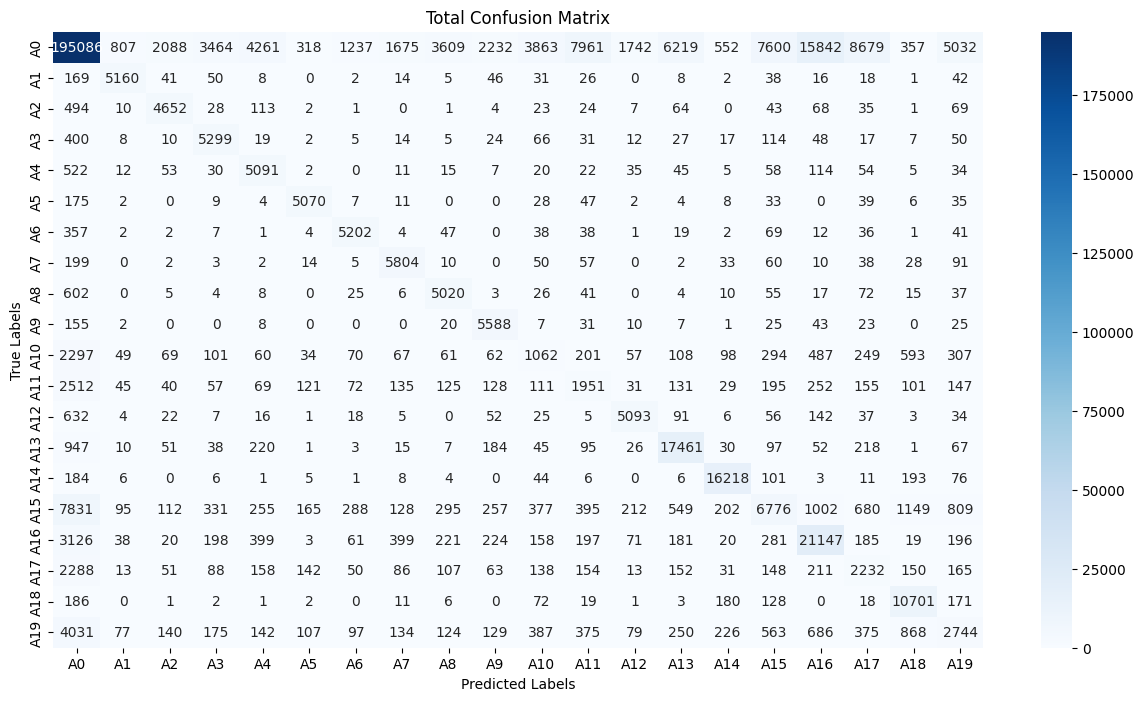

In [69]:
model = GaussianNB()
updated_global_model_weights = UpdateGlobalModel(learning_rate, num_communication_rounds, num_samples , model = model)
# Accuracy values with updated global model
precision, recall, f1, weighted_accuracy = calculate_weighted_metrics_and_plot_conf_matrix(client_data, client_labels, client_test_data, client_test_labels, updated_global_model_weights, model)

In [70]:
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"Weighted F1 Score: {f1}")
print(f"Weighted Accuracy: {weighted_accuracy}")

Weighted Precision: 0.7297243794429488
Weighted Recall: 0.6862278084394794
Weighted F1 Score: 0.6941037898431799
Weighted Accuracy: 0.6862278084394794


## 3.2 DT

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

Evaluating models:   0%|          | 0/2255 [00:00<?, ?it/s]

['A0' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'A10' 'A11' 'A12' 'A13'
 'A14' 'A15' 'A16' 'A17' 'A18' 'A19']


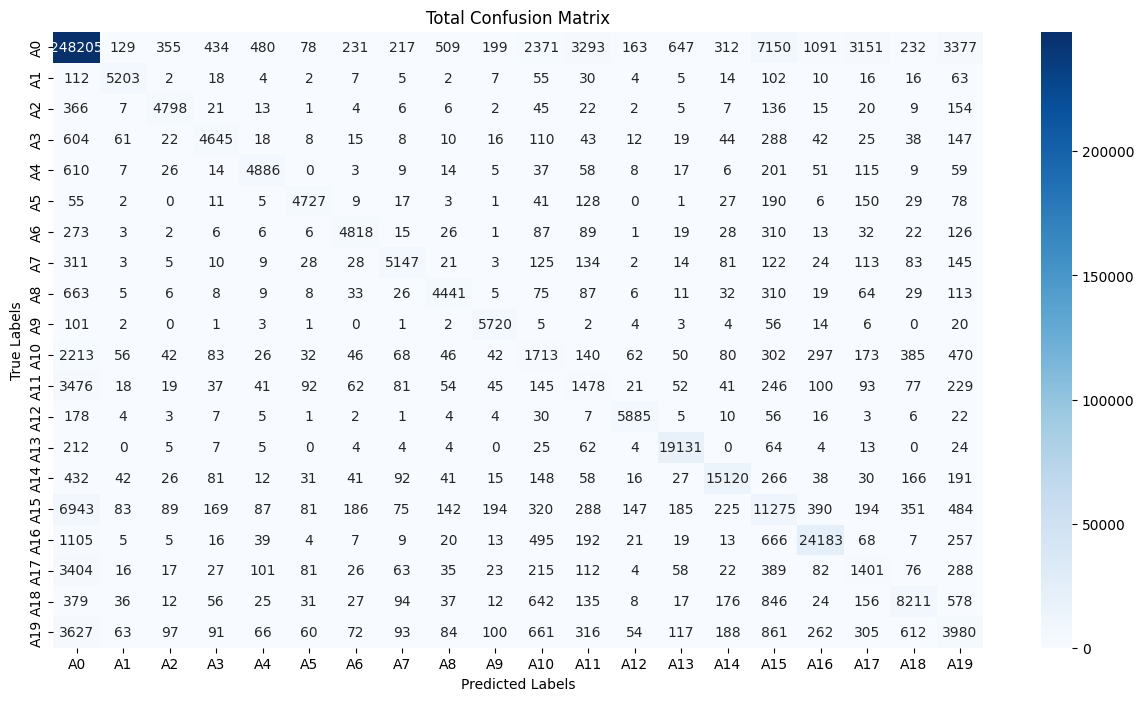

In [71]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
updated_global_model_weights = UpdateGlobalModel(learning_rate, num_communication_rounds, num_samples , model = model)
# Accuracy values with updated global model
precision, recall, f1, weighted_accuracy = calculate_weighted_metrics_and_plot_conf_matrix(client_data, client_labels, client_test_data, client_test_labels, updated_global_model_weights, model)

In [72]:
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"Weighted F1 Score: {f1}")
print(f"Weighted Accuracy: {weighted_accuracy}")

Weighted Precision: 0.8374167676319163
Weighted Recall: 0.8352429435359798
Weighted F1 Score: 0.8360380919656234
Weighted Accuracy: 0.8352429435359798


## 3.3 Logistic Regression

['A0' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'A10' 'A11' 'A12' 'A13'
 'A14' 'A15' 'A16' 'A17' 'A18' 'A19']


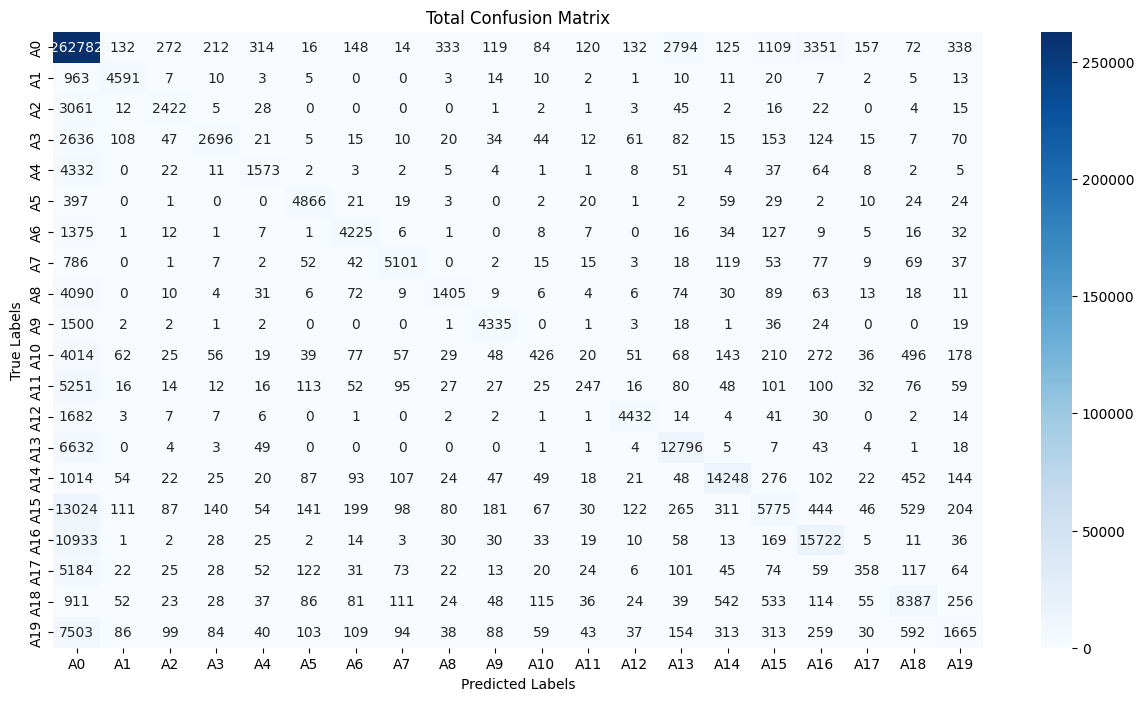

In [73]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver = 'newton-cholesky')
updated_global_model_weights = UpdateGlobalModel(learning_rate, num_communication_rounds, num_samples , model = model)
# Accuracy values with updated global model
precision, recall, f1, weighted_accuracy = calculate_weighted_metrics_and_plot_conf_matrix(client_data, client_labels, client_test_data, client_test_labels, updated_global_model_weights, model)


In [74]:
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"Weighted F1 Score: {f1}")
print(f"Weighted Accuracy: {weighted_accuracy}")

Weighted Precision: 0.738843297778802
Weighted Recall: 0.762336220486494
Weighted F1 Score: 0.7248454916568733
Weighted Accuracy: 0.762336220486494


## 3.4 RF

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

  0%|          | 0/2255 [00:00<?, ?it/s]

Evaluating models:   0%|          | 0/2255 [00:00<?, ?it/s]

['A0' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'A10' 'A11' 'A12' 'A13'
 'A14' 'A15' 'A16' 'A17' 'A18' 'A19']


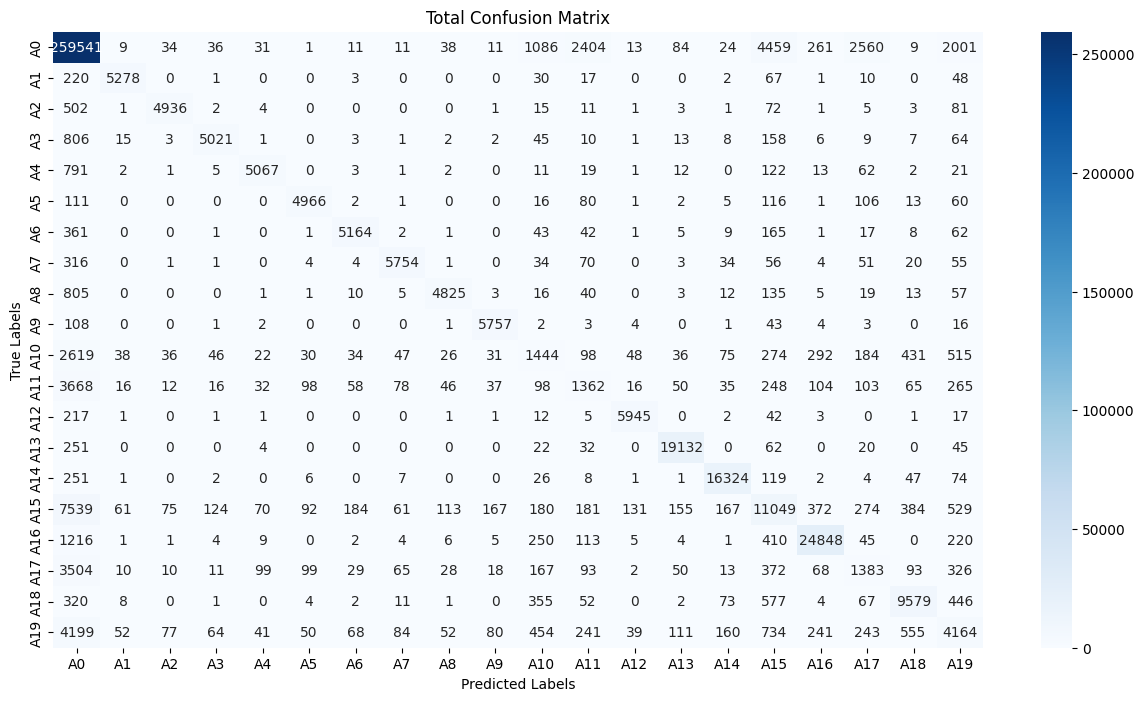

In [75]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=15)
updated_global_model_weights = UpdateGlobalModel(learning_rate, num_communication_rounds, num_samples , model = model)
# Accuracy values with updated global model
precision, recall, f1, weighted_accuracy = calculate_weighted_metrics_and_plot_conf_matrix(client_data, client_labels, client_test_data, client_test_labels, updated_global_model_weights, model)


In [77]:
print(f"Weighted Precision: {precision}")
print(f"Weighted Recall: {recall}")
print(f"Weighted F1 Score: {f1}")
print(f"Weighted Accuracy: {weighted_accuracy}")

Weighted Precision: 0.8607121476552023
Weighted Recall: 0.8709915527937988
Weighted F1 Score: 0.8648892373709526
Weighted Accuracy: 0.8709915527937988
